In [1]:
# ========================== SPEED HEADER (single-BLAS + joblib) ==========================
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

# Parallelism knob (tune to your box; 7950X ~16–24)
N_JOBS = 18

# ============================== Core & Visualization ====================================
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from IPython.display import display

# ============================== ML & Stats ==============================================
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity

from scipy.stats import kstest, norm, t, skewnorm, cauchy, kruskal, levene
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

# ============================== Parallel control ========================================
from threadpoolctl import threadpool_limits
from joblib import Parallel, delayed

# ============================== Optional tests (installed) ===============================
from diptest import diptest  # Hartigan's dip

# ============================== Utilities ===============================================
warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)

# ---- Notebook config toggles ----
ENABLE_CO2_ANALYSIS = True       # set False to skip CO₂ terciles diagnostics
LOS_DEVICES = {"ED0"}            # ED0 is the ONLY LoS device (source of truth)
REPORT_XLIM = (-30, 30)          # plotting window for residual PDFs

def _seeds(base_seed: int, n: int) -> np.ndarray:
    return np.random.default_rng(base_seed).integers(0, 2**32 - 1, size=n, dtype=np.uint32)


Optional columns detected -> fold=fold, device=None, los=None, fitted=None, co2=co2


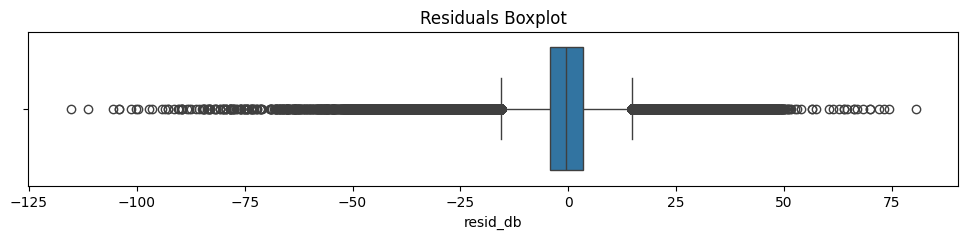

In [2]:
# ============================== Load residuals + discover optional columns ==============================
# pick your residuals CSV (change if needed)
RESID_PATH = "../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF/residuals__POLY2__BEST__oof.csv"

df_res = pd.read_csv(RESID_PATH)

# residual column
res_col = next(c for c in ["resid_db", "residuals", "resid", "error"] if c in df_res.columns)
residuals = df_res[res_col].astype(float)
n = residuals.size

# optional columns (for diagnostics)
col_fold = next((c for c in ["fold", "cv_fold", "group"] if c in df_res.columns), None)
col_dev  = next((c for c in ["device","ed","ED","node","Device","Node"] if c in df_res.columns), None)
col_los  = next((c for c in ["los","LoS","LOS","is_los"] if c in df_res.columns), None)
col_co2  = next((c for c in ["co2","CO2","co2_ppm","CO2_ppm"] if c in df_res.columns), None)
col_fit  = next((c for c in ["fitted","yhat","y_pred","pred"] if c in df_res.columns), None)

print("Optional columns detected ->",
      f"fold={col_fold}, device={col_dev}, los={col_los}, fitted={col_fit}, co2={col_co2}")

# probabilities for Q–Q plots
probabilities = (np.arange(1, n + 1) - 0.5) / n
sorted_residuals = np.sort(residuals)

# derive LoS/NLoS labels (ED0 is LoS if no explicit LoS column)
def derive_los_labels(df):
    if col_los is not None:
        return df[col_los].astype(str).str.upper().map(lambda s: "LOS" if "LOS" in s else "NLOS")
    if col_dev is not None:
        return df[col_dev].astype(str).map(lambda d: "LOS" if d in LOS_DEVICES else "NLOS")
    return None

los_labels = derive_los_labels(df_res)

# quick outlier glimpse
plt.figure(figsize=(12, 2))
sns.boxplot(x=residuals)
plt.title('Residuals Boxplot')
plt.show()


In [3]:
# === Fit Distributions (PARAMETRIC; unchanged) ===

# 1. Normal
loc_norm, scale_norm = norm.fit(residuals)
normal_dist = norm(loc=loc_norm, scale=scale_norm)

# 2. Skew-Normal
shape_sn, loc_sn, scale_sn = skewnorm.fit(residuals)
skew_dist = skewnorm(shape_sn, loc=loc_sn, scale=scale_sn)

# 3. Gaussian Mixture Model (Automated Model Selection)
residuals_array = residuals.values.reshape(-1, 1)
lowest_bic = np.inf
bic_scores = []
n_components_range = range(1, 6)
best_gmm = None

for n_components in n_components_range:
    gmm_tmp = GaussianMixture(n_components=n_components, random_state=42).fit(residuals_array)
    bic_value = gmm_tmp.bic(residuals_array)
    bic_scores.append(bic_value)
    if bic_value < lowest_bic:
        lowest_bic = bic_value
        best_gmm = gmm_tmp

gmm = best_gmm  # Use best based on lowest BIC
print(f"\nSelected GMM with {gmm.n_components} components based on lowest BIC: {lowest_bic}")

# 4. Cauchy
cauchy_params = cauchy.fit(residuals)
cauchy_dist = cauchy(*cauchy_params)

# 5. t-Distribution
df_t, loc_t, scale_t = t.fit(residuals)
t_dist = t(df=df_t, loc=loc_t, scale=scale_t)

# === Compute Log-Likelihood, AIC, BIC, KS ===
def compute_aic_bic(log_likelihood, num_params, num_samples):
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(num_samples) - 2 * log_likelihood
    return aic, bic

# Normal
loglik_norm = np.sum(np.log(normal_dist.pdf(residuals)))
aic_norm, bic_norm = compute_aic_bic(loglik_norm, 2, n)
ks_norm = kstest(residuals, normal_dist.cdf)

# Skew-Normal
loglik_sn = np.sum(np.log(skew_dist.pdf(residuals)))
aic_sn, bic_sn = compute_aic_bic(loglik_sn, 3, n)
ks_sn = kstest(residuals, skew_dist.cdf)

# Robust GMM CDF helper
def gmm_cdf(x, gmm_model):
    x = np.asarray(x)
    means = gmm_model.means_.ravel()
    covs = gmm_model.covariances_
    if covs.ndim == 3:
        covs = covs[:, 0, 0]
    elif covs.ndim == 2:
        covs = covs[:, 0]
    stds = np.sqrt(covs)
    weights = gmm_model.weights_.ravel()
    cdf = np.zeros_like(x, dtype=float)
    for w, m, s in zip(weights, means, stds):
        cdf += w * norm.cdf(x, loc=m, scale=s)
    return cdf

# GMM
loglik_gmm = gmm.score(residuals_array) * n  # average ll * n
# param count univariate: (k-1) weights + k means + k variances = 3k - 1
aic_gmm, bic_gmm = compute_aic_bic(loglik_gmm, 3 * gmm.n_components - 1, n)
ks_gmm = kstest(residuals, lambda x: gmm_cdf(x, gmm))

# Cauchy
loglik_cauchy = np.sum(np.log(cauchy_dist.pdf(residuals)))
aic_cauchy, bic_cauchy = compute_aic_bic(loglik_cauchy, 2, n)
ks_cauchy = kstest(residuals, cauchy_dist.cdf)

# t
loglik_t = np.sum(np.log(t_dist.pdf(residuals)))
aic_t, bic_t = compute_aic_bic(loglik_t, 3, n)
ks_t = kstest(residuals, t_dist.cdf)

# Diagnostics table
diagnostics = pd.DataFrame({
    'Distribution': ['Normal', 'Skew-Normal', 'Gaussian Mixture Model', 'Cauchy', 't-Distribution'],
    'Log-Likelihood': [loglik_norm, loglik_sn, loglik_gmm, loglik_cauchy, loglik_t],
    'AIC': [aic_norm, aic_sn, aic_gmm, aic_cauchy, aic_t],
    'BIC': [bic_norm, bic_sn, bic_gmm, bic_cauchy, bic_t],
    'KS Test Statistic': [ks_norm.statistic, ks_sn.statistic, ks_gmm.statistic, ks_cauchy.statistic, ks_t.statistic],
    'KS Test p-value': [ks_norm.pvalue, ks_sn.pvalue, ks_gmm.pvalue, ks_cauchy.pvalue, ks_t.pvalue]
}).round({'Log-Likelihood': 2, 'AIC': 2, 'BIC': 2, 'KS Test Statistic': 4, 'KS Test p-value': 4})

print("\nDiagnostics Table:")
display(diagnostics)

best_fit = diagnostics.loc[diagnostics['KS Test Statistic'].idxmin()]
print(f"\nBest Fit (Based on KS Test Statistic): {best_fit['Distribution']}\n")



Selected GMM with 3 components based on lowest BIC: 9290363.941447116

Diagnostics Table:


,Distribution,Log-Likelihood,AIC,BIC,KS Test Statistic,KS Test p-value
0,Normal,-4798409.50,9596823.00,9596847.33,0.0716,0.0
1,Skew-Normal,-4763908.35,9527822.70,9527859.19,0.0603,0.0
2,Gaussian Mixture Model,-4645125.32,9290266.64,9290363.94,0.0094,0.0
3,Cauchy,-4811951.23,9623906.47,9623930.79,0.0771,0.0
4,t-Distribution,-4663327.73,9326661.47,9326697.96,0.0270,0.0



Best Fit (Based on KS Test Statistic): Gaussian Mixture Model



In [4]:
# === GMM Diagnostics (K=1..5) ===
residuals_array = residuals.values.reshape(-1, 1)
gmm_models = []
gmm_diagnostics = []

for k in range(1, 6):
    gmm_k = GaussianMixture(n_components=k, random_state=42).fit(residuals_array)
    gmm_models.append(gmm_k)
    loglik_k = np.sum(gmm_k.score_samples(residuals_array))
    num_params = 3 * k - 1
    aic_k = 2 * num_params - 2 * loglik_k
    bic_k = num_params * np.log(len(residuals_array)) - 2 * loglik_k
    ks_result = kstest(residuals, lambda x: gmm_cdf(x, gmm_k))
    gmm_diagnostics.append({
        'GMM Components': k,
        'Log-Likelihood': loglik_k,
        'AIC': aic_k,
        'BIC': bic_k,
        'KS Statistic': ks_result.statistic,
        'KS p-value': ks_result.pvalue
    })

gmm_diag_df = pd.DataFrame(gmm_diagnostics)
print("\n=== GMM Diagnostics (K=1..5) ===\n")
display(gmm_diag_df)

best_gmm_row = gmm_diag_df.loc[gmm_diag_df['BIC'].idxmin()]
best_gmm_components = int(best_gmm_row['GMM Components'])
best_gmm = gmm_models[best_gmm_components - 1]
print(f"\nBest GMM Model based on lowest BIC: {best_gmm_components} components\n")



=== GMM Diagnostics (K=1..5) ===



,GMM Components,Log-Likelihood,AIC,BIC,KS Statistic,KS p-value
0,1,-4.798410e+06,9.596823e+06,9.596847e+06,0.071581,0.000000e+00
1,2,-4.654015e+06,9.308039e+06,9.308100e+06,0.010509,2.932771e-136
2,3,-4.645125e+06,9.290267e+06,9.290364e+06,0.009402,3.926269e-109
3,4,-4.645486e+06,9.290994e+06,9.291128e+06,0.015997,3.748693e-315
4,5,-4.651692e+06,9.303411e+06,9.303582e+06,0.008423,1.114554e-87



Best GMM Model based on lowest BIC: 3 components



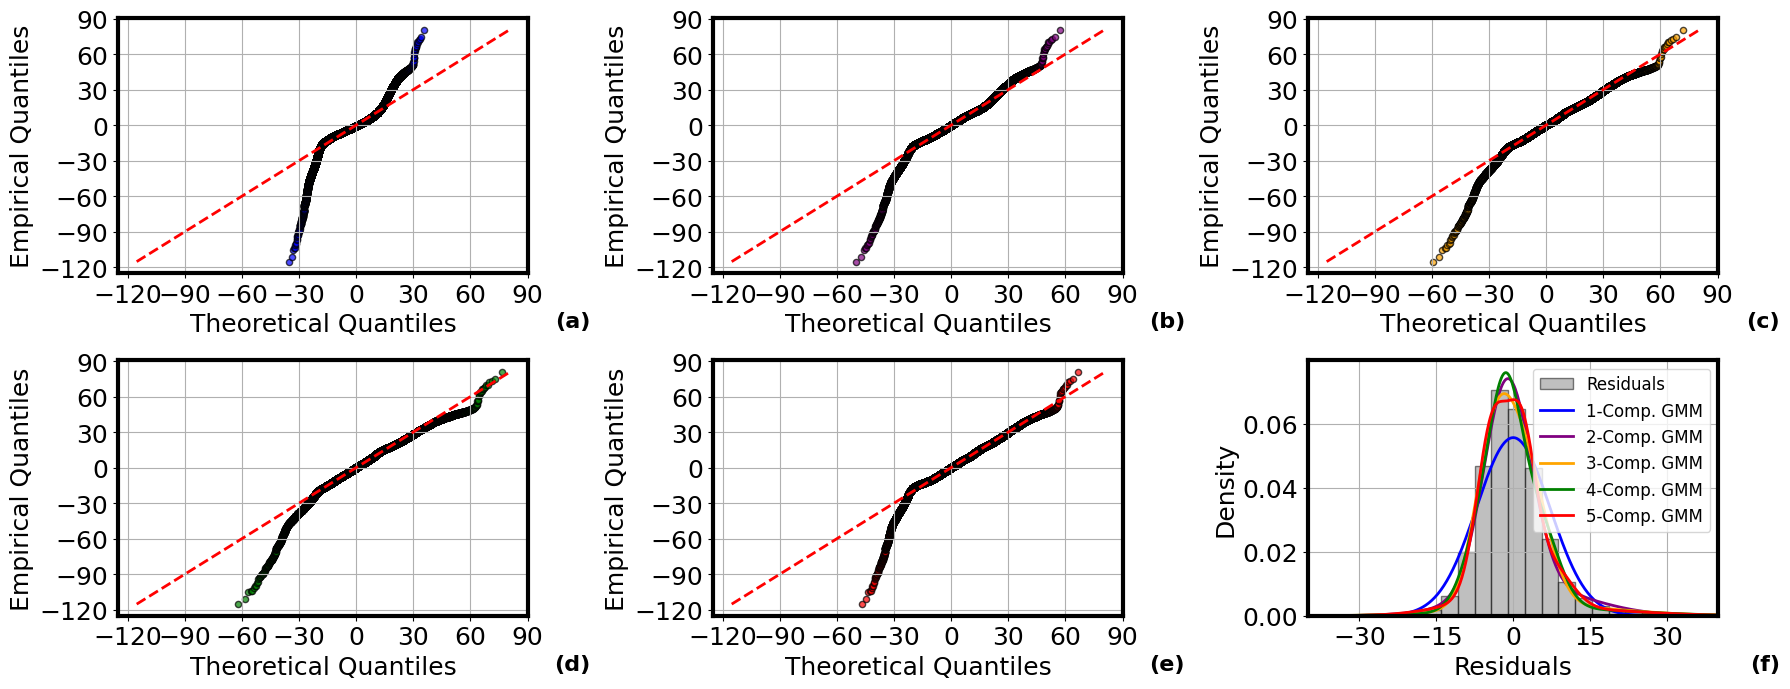

In [5]:
# === GMM Q–Q plots and histogram overlay ===
gmm_models = []
for k in range(1, 6):
    gmm_k = GaussianMixture(n_components=k, random_state=42).fit(residuals_array)
    gmm_models.append(gmm_k)

probs = probabilities  # already defined
fig, axes = plt.subplots(2, 3, figsize=(18, 7))
axes = axes.flatten()
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
gmm_colors = ['blue', 'purple', 'orange', 'green', 'red']

for i, gmm_model in enumerate(gmm_models):
    ax = axes[i]
    x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
    cdf_grid = gmm_cdf(x_grid, gmm_model)
    unique_cdf, unique_idx = np.unique(cdf_grid, return_index=True)
    unique_x = x_grid[unique_idx]
    ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
    theoretical_quantiles = ppf_func(probs)

    ax.scatter(theoretical_quantiles, sorted_residuals, color=gmm_colors[i], alpha=0.7, edgecolors='k', s=20)
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    ax.set_xlabel('Theoretical Quantiles', fontsize=18)
    ax.set_ylabel('Empirical Quantiles', fontsize=18)
    ax.text(1.15, -0.15, subplot_labels[i], transform=ax.transAxes, ha='right', va='top',
            fontweight='bold', fontsize=16)
    ax.grid(True)

ax6 = axes[5]
ax6.hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
for i, gmm_model in enumerate(gmm_models):
    density = np.exp(gmm_model.score_samples(x_vals.reshape(-1, 1)))
    ax6.plot(x_vals, density, color=gmm_colors[i], linewidth=2, label=f'{i+1}-Comp. GMM')
ax6.set_xlabel('Residuals', fontsize=18); ax6.set_ylabel('Density', fontsize=18)
ax6.legend(fontsize=12); ax6.set_xlim(-40, 40); ax6.grid(True)
ax6.text(1.15, -0.15, subplot_labels[5], transform=ax6.transAxes, ha='right', va='top',
         fontweight='bold', fontsize=16)

for i, ax in enumerate(axes):
    if i < 5:
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.yaxis.set_major_locator(MultipleLocator(30))
    elif i == 5:
        ax.xaxis.set_major_locator(MultipleLocator(15))
    ax.tick_params(axis='both', which='major', labelsize=18)
    for spine in ax.spines.values():
        spine.set_linewidth(3)

plt.tight_layout()
plt.show()


In [6]:
# --- Print Distribution Parameters Including Best GMM ---
def print_group(title, params):
    bold_title = f"\033[1m=== {title} ===\033[0m"
    print(bold_title)
    for name, val in params:
        print(f"{name}: {val:.4f}")
    print("-" * 50)

# Normal
print_group("Normal Distribution", [("Mean (μ)", loc_norm), ("Std (σ)", scale_norm)])

# Skew-Normal
print_group("Skew-Normal Distribution", [("Shape", shape_sn), ("Location", loc_sn), ("Scale", scale_sn)])

# Best GMM
bold_title = f"\033[1m=== Gaussian Mixture Model (Best GMM) ===\033[0m"
print(bold_title)
for i in range(best_gmm.n_components):
    w = best_gmm.weights_[i]
    if best_gmm.covariances_.ndim == 3:
        std = np.sqrt(best_gmm.covariances_[i][0][0])
    else:
        std = np.sqrt(best_gmm.covariances_[i])
    mean = best_gmm.means_[i][0]
    print(f"Component {i+1}: weight={w:.4f}, mean={mean:.4f}, std={std:.4f}")
print("-" * 50)

# Cauchy
print_group("Cauchy Distribution", [("Location", cauchy_params[0]), ("Scale", cauchy_params[1])])

# t-Distribution
print_group("t-Distribution", [("Degrees of Freedom (df)", df_t), ("Location", loc_t), ("Scale", scale_t)])


=== Normal Distribution ===
Mean (μ): 0.0000
Std (σ): 7.1705
--------------------------------------------------
=== Skew-Normal Distribution ===
Shape: 1.5531
Location: -6.2628
Scale: 9.5204
--------------------------------------------------
=== Gaussian Mixture Model (Best GMM) ===
Component 1: weight=0.4214, mean=2.4976, std=4.1665
Component 2: weight=0.4645, mean=-3.7510, std=3.7710
Component 3: weight=0.1142, mean=6.0429, std=14.5490
--------------------------------------------------
=== Cauchy Distribution ===
Location: -0.8231
Scale: 3.5021
--------------------------------------------------
=== t-Distribution ===
Degrees of Freedom (df): 3.7632
Location: -0.5691
Scale: 4.9261
--------------------------------------------------


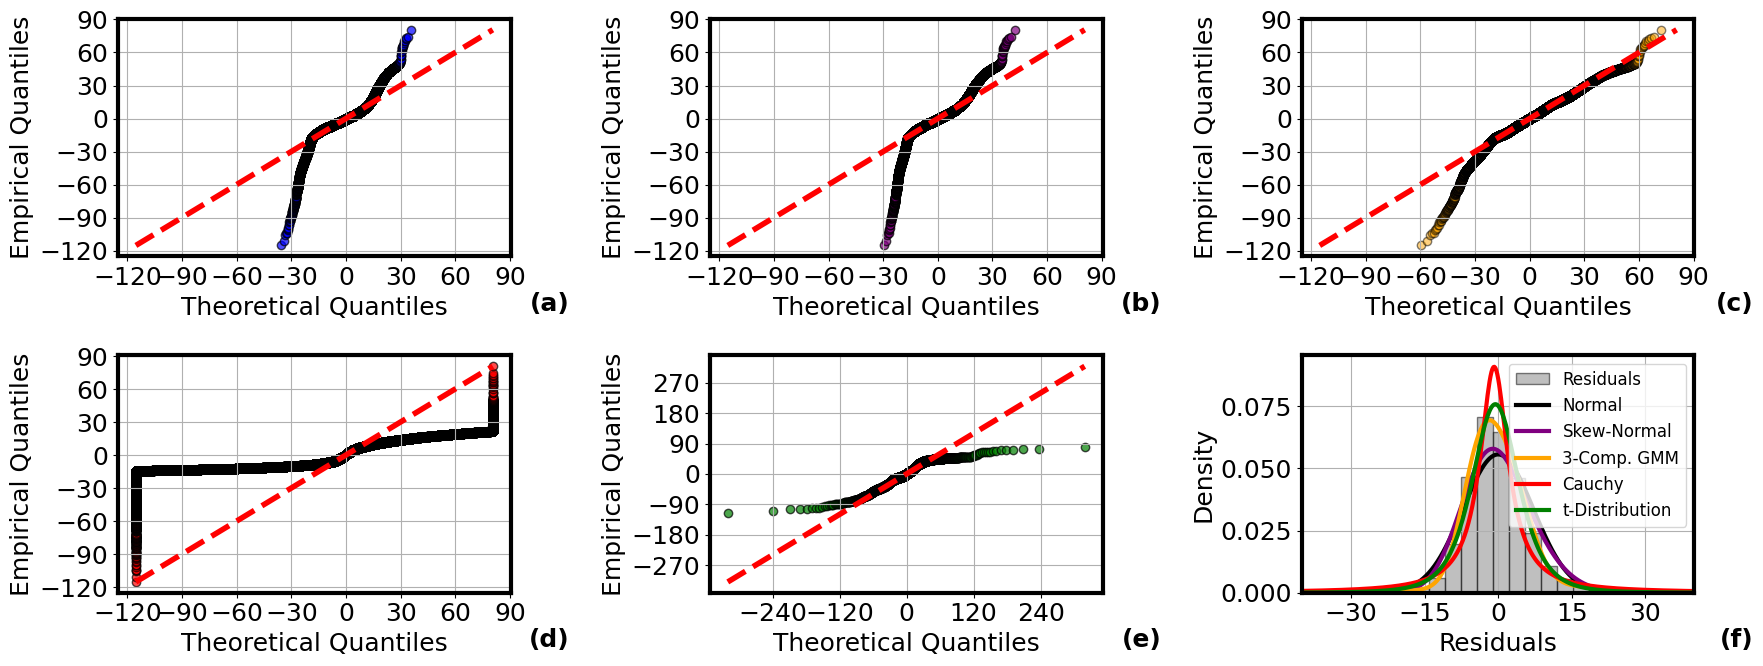

In [7]:
# === Parametric Q–Q grid + histogram with overlaid PDFs ===
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'legend.fontsize': 15
})

fig, axes = plt.subplots(2, 3, figsize=(18, 7))
axes = axes.flatten()
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

def manual_qq_plot(distribution, dist_name, sorted_residuals, probabilities, ax, color='blue'):
    theoretical_quantiles = distribution.ppf(probabilities)
    ax.scatter(theoretical_quantiles, sorted_residuals, edgecolors='k', facecolor=color, alpha=0.7)
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=4)
    ax.set_xlabel('Theoretical Quantiles'); ax.set_ylabel('Empirical Quantiles'); ax.grid(True)

# 1. Normal
manual_qq_plot(normal_dist, 'Normal', sorted_residuals, probabilities, axes[0], color='blue')
axes[0].text(1.15, -0.15, subplot_labels[0], transform=axes[0].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 2. Skew-Normal
manual_qq_plot(skew_dist, 'Skew-Normal', sorted_residuals, probabilities, axes[1], color='purple')
axes[1].text(1.15, -0.15, subplot_labels[1], transform=axes[1].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 3. Best GMM
x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
cdf_grid = gmm_cdf(x_grid, best_gmm)
unique_cdf, unique_indices = np.unique(cdf_grid, return_index=True)
unique_x = x_grid[unique_indices]
ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
theoretical_gmm_quantiles = ppf_func(probabilities)
axes[2].scatter(theoretical_gmm_quantiles, sorted_residuals, edgecolors='k', facecolor='orange', alpha=0.5)
mv = min(theoretical_gmm_quantiles.min(), sorted_residuals.min())
Mx = max(theoretical_gmm_quantiles.max(), sorted_residuals.max())
axes[2].plot([mv, Mx], [mv, Mx], 'r--', linewidth=4)
axes[2].set_xlabel('Theoretical Quantiles'); axes[2].set_ylabel('Empirical Quantiles'); axes[2].grid(True)
axes[2].text(1.15, -0.15, subplot_labels[2], transform=axes[2].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 4. Cauchy
lower_bound, upper_bound = residuals.min(), residuals.max()
theoretical_quantiles = cauchy_dist.ppf(probabilities)
theoretical_quantiles_clipped = np.clip(theoretical_quantiles, lower_bound, upper_bound)
axes[3].scatter(theoretical_quantiles_clipped, sorted_residuals, edgecolors='k', facecolor='red', alpha=0.7)
axes[3].plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'r--', linewidth=4)
axes[3].set_xlabel('Theoretical Quantiles'); axes[3].set_ylabel('Empirical Quantiles'); axes[3].grid(True)
axes[3].text(1.15, -0.15, subplot_labels[3], transform=axes[3].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 5. t-Distribution
manual_qq_plot(t_dist, 't-', sorted_residuals, probabilities, axes[4], color='green')
axes[4].text(1.15, -0.15, subplot_labels[4], transform=axes[4].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 6. Histogram + PDFs
axes[5].hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
axes[5].plot(x_vals, normal_dist.pdf(x_vals), label='Normal', color='black', linewidth=3)
axes[5].plot(x_vals, skew_dist.pdf(x_vals), label='Skew-Normal', color='purple', linewidth=3)
gmm_density = np.exp(best_gmm.score_samples(x_vals.reshape(-1, 1)))
axes[5].plot(x_vals, gmm_density, label=f'{best_gmm.n_components}-Comp. GMM', color='orange', linewidth=3)
axes[5].plot(x_vals, cauchy_dist.pdf(x_vals), label='Cauchy', color='red', linewidth=3)
axes[5].plot(x_vals, t_dist.pdf(x_vals), label='t-Distribution', color='green', linewidth=3)
axes[5].set_xlabel('Residuals'); axes[5].set_ylabel('Density'); axes[5].legend(fontsize=12); axes[5].grid(True)
axes[5].set_xlim(-40, 40)
axes[5].text(1.15, -0.15, subplot_labels[5], transform=axes[5].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

for i, ax in enumerate(axes):
    if i < 4:
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.yaxis.set_major_locator(MultipleLocator(30))
    elif i == 4:
        ax.xaxis.set_major_locator(MultipleLocator(120))
        ax.yaxis.set_major_locator(MultipleLocator(90))
    else:
        ax.xaxis.set_major_locator(MultipleLocator(15))
    ax.tick_params(axis='both', which='major', labelsize=18)
    for spine in ax.spines.values():
        spine.set_linewidth(3)

plt.tight_layout()
plt.show()


[Dip]       dip=0.004243, p=0
[Silverman] h*=0.99992, p=0.7000  (H0: ≤1 mode)


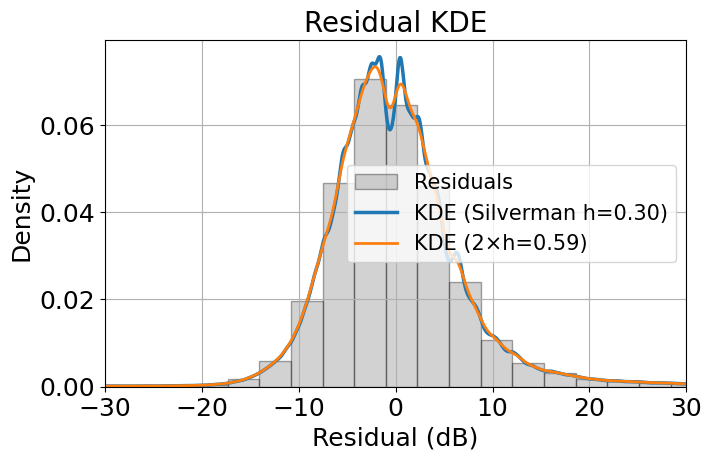

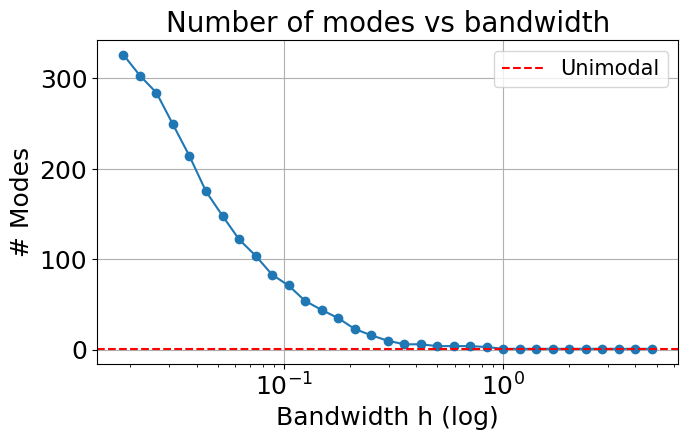

In [8]:
# ============================== Non-parametric residual diagnostics ==============================

def silverman_bw(x: np.ndarray) -> float:
    x = np.asarray(x).ravel()
    sigma = np.std(x, ddof=1)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    s = min(sigma, iqr / 1.349) if np.isfinite(iqr) and iqr > 0 else sigma
    return 0.9 * s * (x.size ** (-1/5))

def count_modes_from_kde_model(kde_model, grid: np.ndarray) -> int:
    y = np.exp(kde_model.score_samples(grid.reshape(-1, 1)))
    peaks, _ = find_peaks(y)
    return peaks.size

def silverman_crit_unimodal_parallel(
    x: np.ndarray,
    alpha_modes: int = 1,
    B: int = 199,
    grid: np.ndarray = None,
    n_jobs: int = N_JOBS,
    seed: int = 42,
):
    x = np.asarray(x).ravel()
    if grid is None:
        lo, hi = np.percentile(x, [1, 99])
        grid = np.linspace(lo, hi, 1201)

    h0 = silverman_bw(x)
    h_grid = np.sort(h0 * (2.0 ** np.linspace(-3, +3, 25)))

    def modes_for_h(h, arr):
        km = KernelDensity(kernel="gaussian", bandwidth=h).fit(arr[:, None])
        return count_modes_from_kde_model(km, grid)

    # observed h*
    hcrit = float(h_grid[-1])
    for h in h_grid:
        if modes_for_h(h, x) <= alpha_modes:
            hcrit = float(h); break

    # bootstrap (parallel)
    n = x.size
    seeds = _seeds(seed, B)

    def one_boot(s):
        with threadpool_limits(1):
            r = np.random.default_rng(int(s))
            xb = x[r.integers(0, n, n)] + hcrit * r.standard_normal(n)
            hb = float(h_grid[-1])
            for h in h_grid:
                if modes_for_h(h, xb) <= alpha_modes:
                    hb = float(h); break
            return hb

    hb_list = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(one_boot)(s) for s in seeds)
    count = sum(hb <= hcrit for hb in hb_list)
    pval = (count + 1) / (B + 1)
    return hcrit, pval

# ----------------- Run non-parametric suite -----------------
x = residuals.values.astype(float)
x_grid = np.linspace(*REPORT_XLIM, 1201)

# KDEs
h_silv = silverman_bw(x)
kde_s = KernelDensity(kernel="gaussian", bandwidth=h_silv).fit(x.reshape(-1, 1))
kde_2s = KernelDensity(kernel="gaussian", bandwidth=2*h_silv).fit(x.reshape(-1, 1))
dens_s = np.exp(kde_s.score_samples(x_grid.reshape(-1,1)))
dens_2s = np.exp(kde_2s.score_samples(x_grid.reshape(-1,1)))

# Dip
dip_d, dip_p = diptest(x)

# Silverman (parallel)
hcrit, p_silv = silverman_crit_unimodal_parallel(x, alpha_modes=1, B=199,
                                                 grid=x_grid, n_jobs=N_JOBS, seed=42)

print(f"[Dip]       dip={dip_d:.6f}, p={dip_p:.4g}")
print(f"[Silverman] h*={hcrit:.5f}, p={p_silv:.4f}  (H0: ≤1 mode)")

# Plot KDE
plt.figure(figsize=(7.5, 4.5))
plt.hist(x, bins=60, density=True, alpha=0.35, color='grey', edgecolor='black', label='Residuals')
plt.plot(x_grid, dens_s,  lw=2.5, label=f'KDE (Silverman h={h_silv:.2f})')
plt.plot(x_grid, dens_2s, lw=2.0, label=f'KDE (2×h={2*h_silv:.2f})')
plt.xlim(*REPORT_XLIM)
plt.xlabel('Residual (dB)'); plt.ylabel('Density'); plt.title('Residual KDE')
plt.grid(True); plt.legend(); plt.show()

# Modes vs bandwidth (parallel)
hs_scan = h_silv * (2.0 ** np.linspace(-4, +4, 33))
def modes_at_h(h):
    with threadpool_limits(1):
        km = KernelDensity(kernel="gaussian", bandwidth=h).fit(x.reshape(-1,1))
        return h, count_modes_from_kde_model(km, x_grid)
modes_scan = Parallel(n_jobs=N_JOBS, prefer="threads")(delayed(modes_at_h)(h) for h in hs_scan)

plt.figure(figsize=(7.5, 4.2))
plt.plot([h for h,_ in modes_scan], [m for _,m in modes_scan], marker='o')
plt.axhline(1, color='r', ls='--', lw=1.5, label='Unimodal')
plt.xscale('log'); plt.xlabel('Bandwidth h (log)'); plt.ylabel('# Modes')
plt.title('Number of modes vs bandwidth')
plt.grid(True); plt.legend(); plt.show()


In [9]:
# ============================== Non-parametric group diagnostics ==============================

def print_kw_bf(name, groups):
    # Kruskal–Wallis (medians)
    kw_stat, kw_p = kruskal(*groups)
    # Brown–Forsythe (median-centered Levene)
    bf_stat, bf_p = levene(*groups, center='median')
    print(f"[{name}] Kruskal–Wallis: stat={kw_stat:.3f}, p={kw_p:.3e}")
    print(f"[{name}] Brown–Forsythe: stat={bf_stat:.3f}, p={bf_p:.3e}")

# 1) LoS vs NLoS
if los_labels is not None:
    g_los  = residuals[los_labels == "LOS"].values
    g_nlos = residuals[los_labels == "NLOS"].values
    if g_los.size > 0 and g_nlos.size > 0:
        print(f"LoS count={g_los.size}, NLoS count={g_nlos.size}")
        print_kw_bf("LoS vs NLoS", [g_los, g_nlos])
    else:
        print("[Info] LoS/NLoS groups not sufficiently populated; skipping.")
else:
    print("[Info] No LoS grouping available; skipping LoS/NLoS tests.")

# 2) CO₂ terciles (optional)
if ENABLE_CO2_ANALYSIS and (col_co2 is not None):
    q33, q66 = df_res[col_co2].quantile([0.33, 0.66]).values
    bins = [-np.inf, q33, q66, np.inf]
    labels = ["Low CO2", "Mid CO2", "High CO2"]
    co2_bin = pd.cut(df_res[col_co2], bins=bins, labels=labels)
    groups = [residuals[co2_bin == lab].values for lab in labels]
    if all(g.size > 0 for g in groups):
        print(f"CO₂ group sizes: {[g.size for g in groups]}")
        print_kw_bf("CO₂ terciles", groups)
    else:
        print("[Info] CO₂ tercile groups not sufficiently populated; skipping.")
else:
    print("[Info] CO₂ analysis disabled or CO₂ column missing; skipping.")


[Info] No LoS grouping available; skipping LoS/NLoS tests.
CO₂ group sizes: [474649, 462248, 479016]
[CO₂ terciles] Kruskal–Wallis: stat=243.840, p=1.124e-53
[CO₂ terciles] Brown–Forsythe: stat=74.681, p=3.698e-33
